In [85]:
RANDOM_SEED=1

import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib as mp
import matplotlib.pyplot as plt  # static plotting

# modeling routines from Scikit Learn packages
import sklearn.linear_model 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score  
from math import sqrt  # for root mean-squared error calculation

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, log_loss,accuracy_score

import warnings
warnings.simplefilter(action='ignore')

#load train csv
train=pd.read_csv("train.csv")
train_data=train
#load test csv
test=pd.read_csv("test.csv")
test_data=test


In [86]:
def corr_chart(df_corr):
    corr=df_corr.corr()
    #screen top half to get a triangle
    top = np.zeros_like(corr, dtype=np.bool)
    top[np.triu_indices_from(top)] = True
    fig=plt.figure()
    fig, ax = plt.subplots(figsize=(12,12))
    sb.heatmap(corr, mask=top, cmap='coolwarm', 
        center = 0, square=True, 
        linewidths=.5, cbar_kws={'shrink':.5}, 
        annot = True, annot_kws={'size': 9}, fmt = '.3f')           
    plt.xticks(rotation=45) # rotate variable labels on columns (x axis)
    plt.yticks(rotation=0) # use horizontal variable labels on rows (y axis)
    plt.title('Correlation Heat Map')

In [87]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [88]:
test_data.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


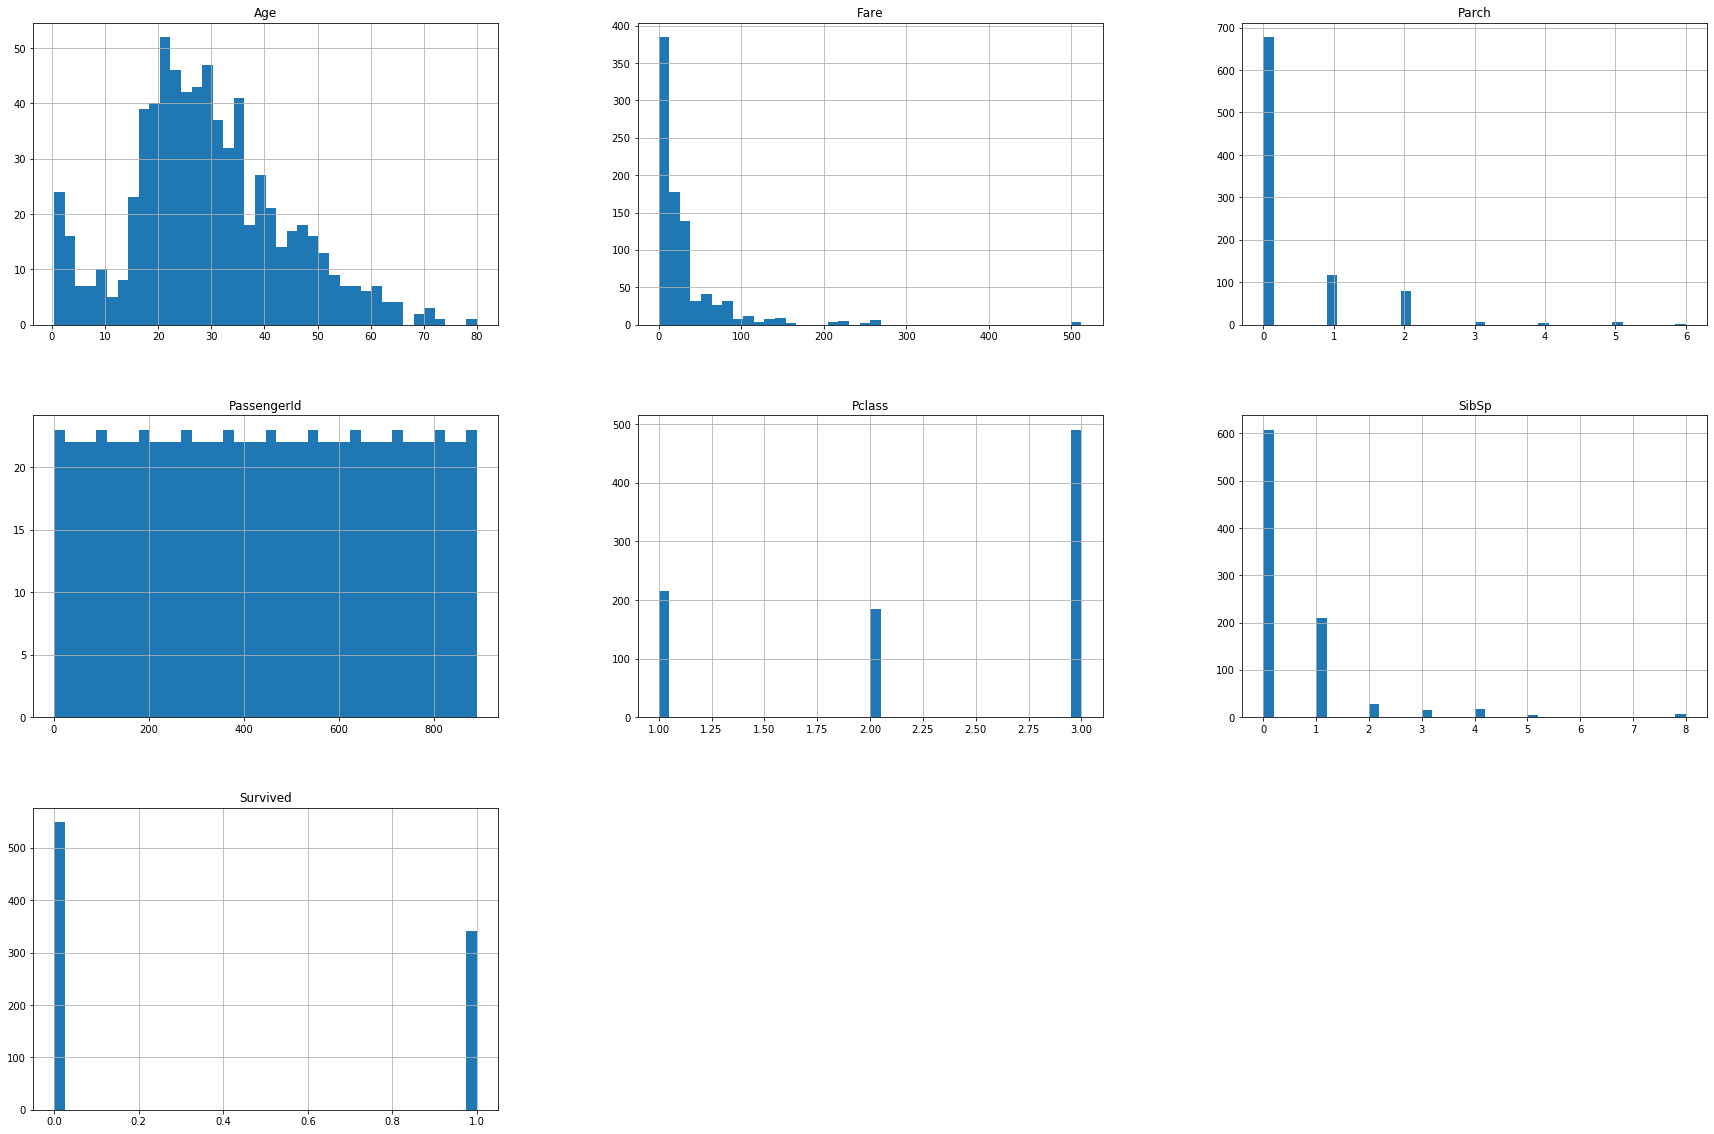

In [89]:
train_data.hist(bins=40,figsize=(30,20));
plt.show()

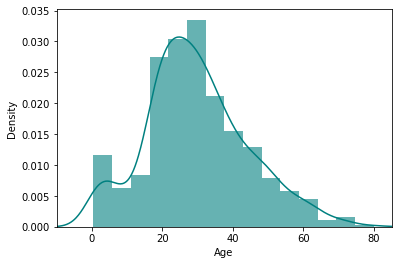

In [90]:
# Age distribution
age_dist = train_data["Age"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_data["Age"].plot(kind='density', color='teal')
age_dist.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

In [91]:
# Embarked - missing values
print('Percent of missing "Embarked" records is %.2f%%' %((train_data['Embarked'].isnull().sum()/train_data.shape[0])*100))

Percent of missing "Embarked" records is 0.22%


Boarded passengers grouped by port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton):
S    644
C    168
Q     77
Name: Embarked, dtype: int64


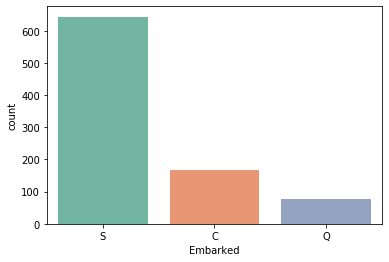

In [92]:
print('Boarded passengers grouped by port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton):')
print(train_data['Embarked'].value_counts())
sb.countplot(x='Embarked', data=train_data, palette='Set2')
plt.show()

In [93]:
# Cabin - missing values
print('Percent of missing "Cabin" records is %.2f%%' %((train_data['Cabin'].isnull().sum()/train_data.shape[0])*100))

Percent of missing "Cabin" records is 77.10%


In [94]:
#find mean and median for Age
age_mean=train_data['Age'].mean(skipna=True)
age_median=train_data["Age"].median(skipna=True)

In [95]:

# fill missing age values with median value on train and test as median is a round number
train_data['Age'].fillna(age_median,inplace=True)
test_data['Age'].fillna(age_median,inplace=True)

# create a new variable based on age and if the passenger is a minor
train_data['IsMinor']=np.where(train_data['Age']<=16,1,0)
test_data['IsMinor']=np.where(test_data['Age']<=16,1,0)

In [96]:
## Create categorical variable for traveling alone
train_data['TravelAlone']=np.where((train_data["SibSp"]+train_data["Parch"])>0, 0, 1)
test_data['TravelAlone']=np.where((test_data["SibSp"]+test_data["Parch"])>0, 0, 1)

#train_data.drop('SibSp', axis=1, inplace=True)
#train_data.drop('Parch', axis=1, inplace=True)

In [97]:
# fill missing Embarked values with 'S'
train_data["Embarked"].fillna(train_data['Embarked'].value_counts().idxmax(), inplace=True)
test_data["Embarked"].fillna(train_data['Embarked'].value_counts().idxmax(), inplace=True)

In [98]:
emb_data=pd.get_dummies(train_data, columns=['Pclass'])
emb_data.describe()

train_data=emb_data

emb_data=pd.get_dummies(test_data, columns=['Pclass'])
emb_data.describe()

test_data=emb_data

In [99]:
#Selected features
sel_cols=['PassengerId','Survived','Age','IsMinor','Sex','Pclass_1','Pclass_2','Pclass_3','TravelAlone']
train_feature_data=train_data.loc[:,sel_cols]
train_feature_data.describe()


,PassengerId,Survived,Age,IsMinor,Pclass_1,Pclass_2,Pclass_3,TravelAlone
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,29.361582,0.112233,0.242424,0.206510,0.551066,0.602694
std,257.353842,0.486592,13.019697,0.315831,0.428790,0.405028,0.497665,0.489615
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,446.000000,0.000000,28.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,668.500000,1.000000,35.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,891.000000,1.000000,80.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [100]:
test_feature_data=test_data.loc[:,sel_cols]
test_feature_data.describe()

,PassengerId,Survived,Age,IsMinor,Pclass_1,Pclass_2,Pclass_3,TravelAlone
count,418.000000,0.0,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,1100.500000,NaN,29.805024,0.081340,0.255981,0.222488,0.521531,0.605263
std,120.810458,NaN,12.667969,0.273684,0.436934,0.416416,0.500135,0.489380
min,892.000000,NaN,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,996.250000,NaN,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1100.500000,NaN,28.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,1204.750000,NaN,35.750000,0.000000,1.000000,0.000000,1.000000,1.000000
max,1309.000000,NaN,76.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [101]:
train_feature_data.dropna()
train_feature_data.describe()

,PassengerId,Survived,Age,IsMinor,Pclass_1,Pclass_2,Pclass_3,TravelAlone
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,29.361582,0.112233,0.242424,0.206510,0.551066,0.602694
std,257.353842,0.486592,13.019697,0.315831,0.428790,0.405028,0.497665,0.489615
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,446.000000,0.000000,28.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,668.500000,1.000000,35.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,891.000000,1.000000,80.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [102]:
convert_to_binary={'male':0,'female':1}
train_sex=train_feature_data['Sex'].map(convert_to_binary)
train_feature_data['Sex']=train_sex

test_sex=test_feature_data['Sex'].map(convert_to_binary)
test_feature_data['Sex']=test_sex

In [103]:
train_feature_data

,PassengerId,Survived,Age,IsMinor,Sex,Pclass_1,Pclass_2,Pclass_3,TravelAlone
0,1,0,22.0,0,0,0,0,1,0
1,2,1,38.0,0,1,1,0,0,0
2,3,1,26.0,0,1,0,0,1,1
3,4,1,35.0,0,1,1,0,0,0
4,5,0,35.0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...
886,887,0,27.0,0,0,0,1,0,1
887,888,1,19.0,0,1,1,0,0,1
888,889,0,28.0,0,1,0,0,1,0
889,890,1,26.0,0,0,1,0,0,1


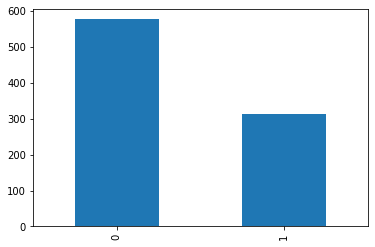

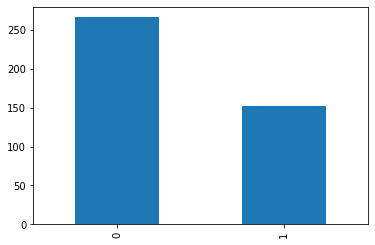

In [104]:
# feature sex to convert to class
train_feature_data['Sex'].value_counts().plot(kind="bar")
plt.show()

test_feature_data['Sex'].value_counts().plot(kind="bar")
plt.show()

<Figure size 432x288 with 0 Axes>

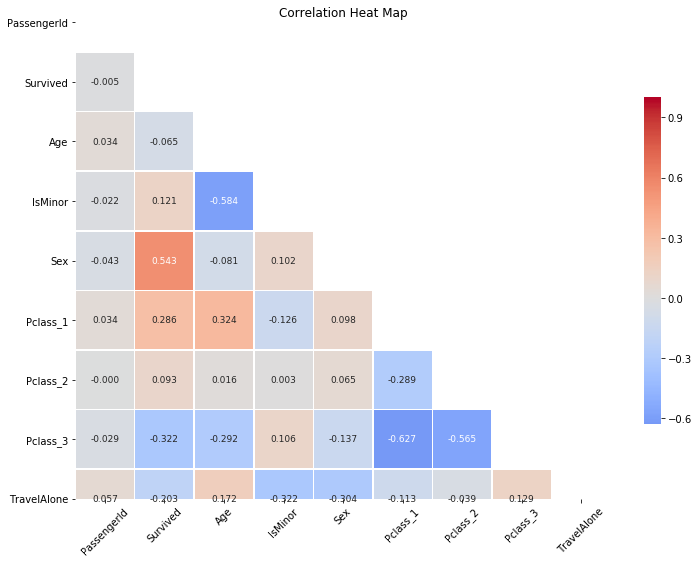

In [105]:
corr_chart(df_corr = train_feature_data)

In [106]:
feature_cols=['Sex','IsMinor','TravelAlone','Pclass_1','Pclass_2','Pclass_3']
train_X=train_feature_data[feature_cols]
train_Y=train_feature_data['Survived']

test_X=test_feature_data[feature_cols]

from sklearn.model_selection import train_test_split
lin_train_x, lin_test_x,lin_train_y,lin_test_y=train_test_split(train_X,train_Y, test_size=.4,random_state=10)


In [107]:
#Logistic Regrerssion
log_reg=LogisticRegression(solver='lbfgs')
log_reg.fit(lin_train_x,lin_train_y)
log_y_pred=log_reg.predict(lin_test_x)
log_y_pred_proba = log_reg.predict_proba(lin_test_x)[:, 1]

log_res=roc_auc_score(lin_test_y,log_y_pred)
log_res


0.7556120360262009

In [108]:
log_cnf_matrix=metrics.confusion_matrix(lin_test_y,log_y_pred)
log_cnf_matrix

[fpr, tpr, thr] = roc_curve(lin_test_y, log_y_pred)
print(" accuracy is %2.3f" % accuracy_score(lin_test_y, log_y_pred))
print(" log_loss is %2.3f" % log_loss(lin_test_y, log_y_pred_proba))
print(" auc is %2.3f" % auc(fpr, tpr))

 accuracy is 0.782
 log_loss is 0.454
 auc is 0.756


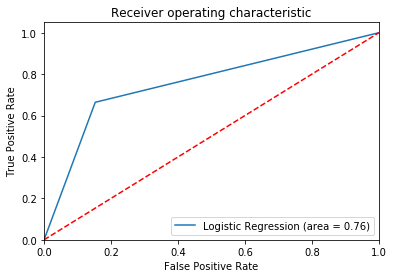

In [109]:
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % log_res)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [110]:
test_feature_data['Log_Predict']=log_reg.predict(test_X)

In [111]:
#Naive Bayes Classification
from sklearn.naive_bayes import BernoulliNB
bern_class=BernoulliNB(alpha=1.0, binarize=0.5, 
                           class_prior = [0.5, 0.5], fit_prior=False)

bern_class.fit(lin_train_x,lin_train_y)
bern_y_pred=bern_class.predict(lin_test_x)
bern_y_pred_proba = bern_class.predict_proba(lin_test_x)[:, 1]

bern_res=roc_auc_score(lin_test_y,bern_y_pred)
bern_res

0.7785719159388647

In [112]:
bern_cnf_matrix=metrics.confusion_matrix(lin_test_y,bern_y_pred)
bern_cnf_matrix

[fpr, tpr, thr] = roc_curve(lin_test_y, bern_y_pred)
print(" accuracy is %2.3f" % accuracy_score(lin_test_y, bern_y_pred))
print(" log_loss is %2.3f" % log_loss(lin_test_y, bern_y_pred_proba))
print(" auc is %2.3f" % auc(fpr, tpr))

 accuracy is 0.754
 log_loss is 0.473
 auc is 0.779


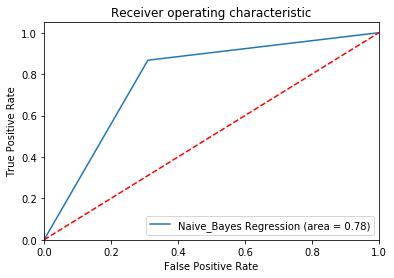

In [113]:
plt.figure()
plt.plot(fpr, tpr, label='Naive_Bayes Regression (area = %0.2f)' % bern_res)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Bayes_ROC')
plt.show()

In [114]:
test_feature_data['Bern_Predict']=bern_class.predict(test_X)

In [115]:
final_data=test_feature_data.loc[:,['PassengerId','Log_Predict','Bern_Predict']]
final_data.to_csv("test_data.csv",index=False)